In [220]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, AutoRegressiveBaseModel,AutoRegressiveBaseModelWithCovariates
from pytorch_forecasting.metrics import MAE,RMSE
import os
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_forecasting.models.nn import LSTM
from typing import Dict
from sklearn.preprocessing import StandardScaler

In [221]:
stream = pd.read_pickle(os.path.join('..','data','processed','stream_processed.pkl'),compression= 'zip')
meteo = pd.read_pickle(os.path.join('..','data','processed','meteo_processed.pkl'),compression = 'zip')
stream

measurement_location,Datum,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,15217908,15221009,15228008,15241006,15242304,15243001,15246000,15247002,15247501
0,2014-01-01,14.4,17.2,19.8,3.87,8.66,9.66,0.433,2.35,0.207,1.66,0.921,0.671,2.59,0.253,0.870,1.26,2.35,0.355,0.120
1,2014-01-02,14.4,17.0,19.3,3.78,8.52,9.46,0.435,2.51,0.204,1.62,0.909,0.664,2.57,0.253,0.870,1.23,2.32,0.361,0.131
2,2014-01-03,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,0.907,0.641,2.58,0.253,0.871,1.23,2.30,0.362,0.130
3,2014-01-04,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,0.935,0.642,2.60,0.256,0.929,1.26,2.44,0.382,0.127
4,2014-01-05,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,1.130,0.690,3.10,0.300,1.150,1.61,3.14,0.561,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-12-28,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,6.070,3.920,12.20,0.786,3.270,9.05,12.50,2.020,0.741
3649,2023-12-29,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,5.480,3.470,10.90,0.653,2.890,7.23,9.97,1.750,0.619
3650,2023-12-30,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,4.900,3.100,9.77,0.557,2.550,5.92,8.54,1.470,0.514
3651,2023-12-31,59.1,63.0,77.3,22.20,35.30,42.50,1.410,13.10,0.669,8.83,4.480,2.670,8.92,0.492,2.330,5.40,7.66,1.290,0.458


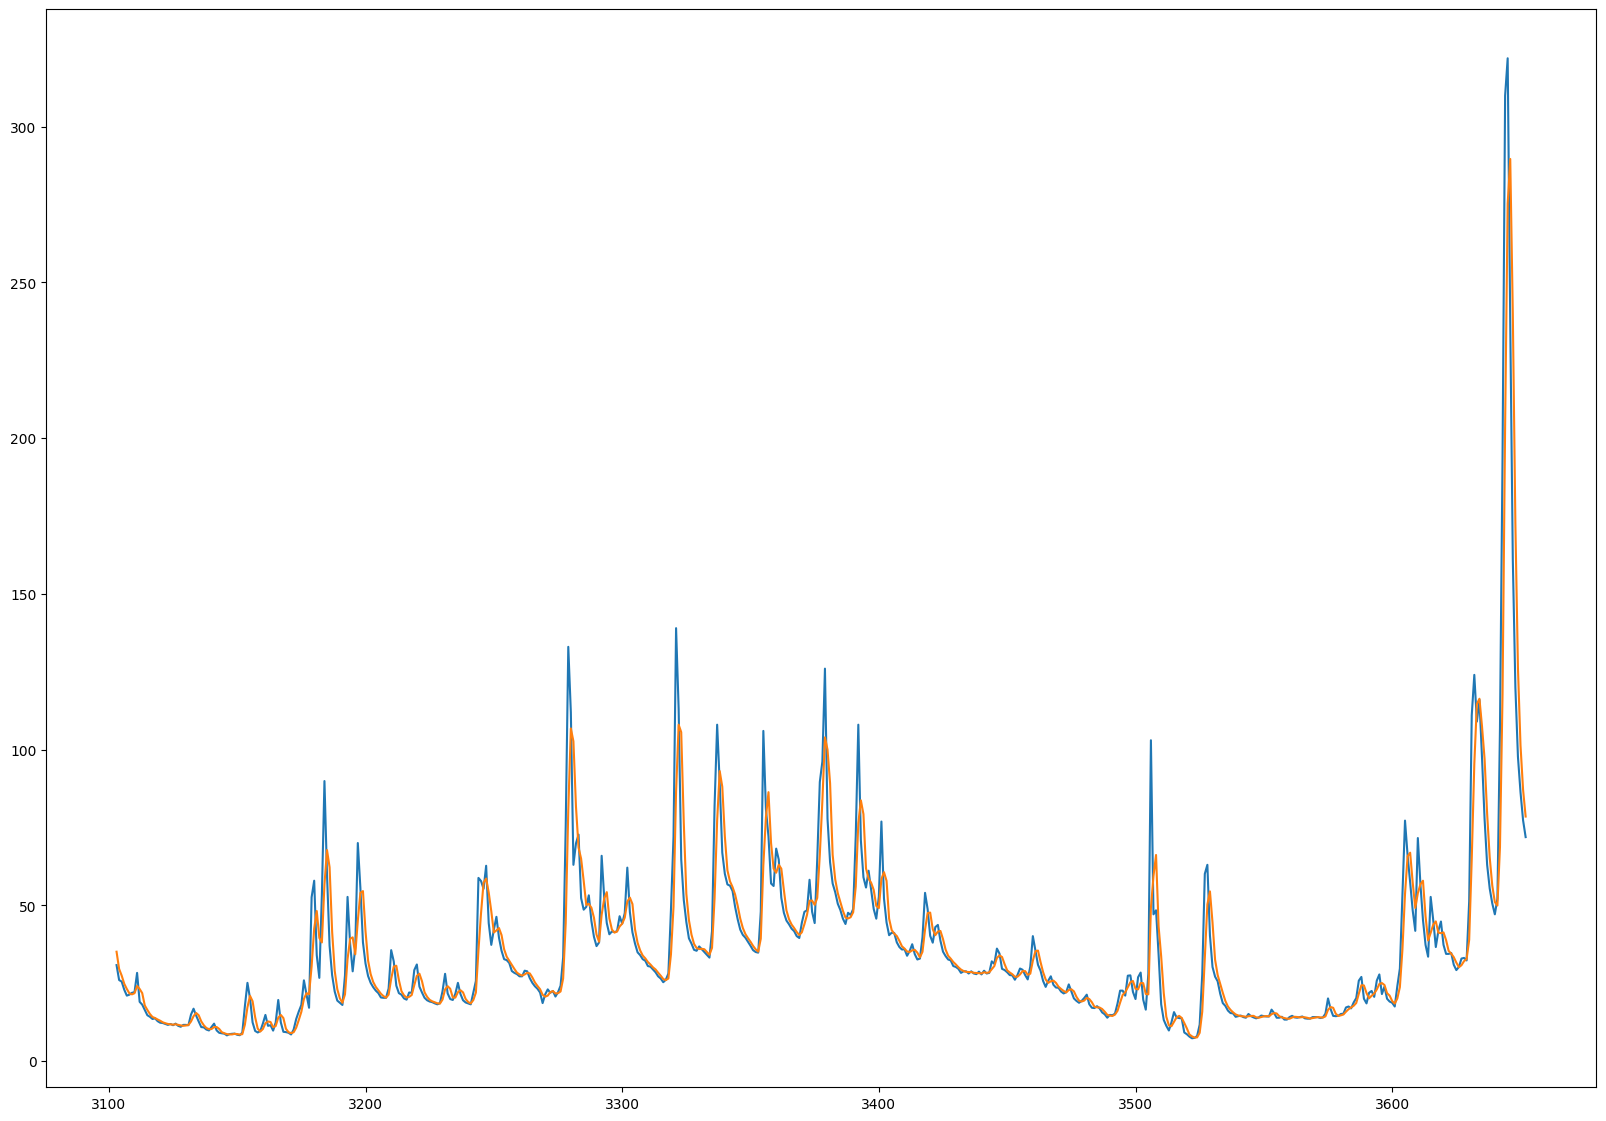

In [222]:
stream['15207507_smooth'] = stream['15207507'].rolling(window=3).mean()

plt.figure(figsize=(20, 14))

plt.plot(stream['15207507'].iloc[-550:])
plt.plot(stream['15207507_smooth'].iloc[-550:])

In [223]:
stream = stream.iloc[:3652]
meteo = meteo.shift(7).drop(columns = 'date')
data = stream.join(meteo).drop(columns = 'Datum').dropna()
data['groups'] = 0
data['date'] = data.index
data

,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,...,tp_8600,tp_8711,tp_8712,tp_8720,tp_8731,tp_8732,tp_8800,tp_8900,groups,date
7,15.2,18.4,21.0,3.93,9.41,10.1,0.464,2.62,0.276,1.68,...,4.265803e-07,4.822628e-07,4.819734e-07,1.253954e-06,5.777455e-07,1.436822e-06,9.707704e-07,3.421187e-07,0,7
8,14.8,17.8,20.6,3.99,9.73,10.3,0.457,2.84,0.333,1.70,...,6.833090e-06,6.702358e-06,6.630144e-06,3.969168e-06,6.355495e-06,3.869216e-06,6.033745e-06,7.608540e-06,0,8
9,17.8,18.9,20.5,5.59,12.60,12.7,0.565,3.92,0.383,2.15,...,9.848191e-07,1.117973e-06,9.627160e-07,3.152130e-07,6.812810e-07,1.552123e-07,2.603002e-07,6.997454e-07,0,9
10,19.0,22.2,24.7,5.00,11.80,12.4,0.512,3.13,0.284,1.98,...,2.306176e-04,2.309710e-04,2.262798e-04,1.507445e-04,2.086118e-04,1.238402e-04,1.149645e-04,2.004822e-04,0,10
11,16.9,20.2,24.1,4.98,11.70,12.2,0.527,3.08,0.318,2.05,...,1.084148e-04,1.048100e-04,1.079762e-04,1.110781e-04,1.135130e-04,1.155993e-04,1.087480e-04,1.086862e-04,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,95.2,138.0,161.0,32.60,54.00,67.8,2.210,21.50,0.993,9.91,...,4.121722e-04,3.853168e-04,4.004076e-04,2.939815e-04,4.179928e-04,3.102297e-04,3.541166e-04,4.240793e-04,0,3647
3648,79.7,102.0,120.0,28.50,46.20,57.1,1.900,17.30,0.721,10.30,...,1.018807e-03,9.318382e-04,9.861434e-04,7.269364e-04,1.059734e-03,7.984520e-04,1.050843e-03,1.157901e-03,0,3648
3649,71.4,82.5,97.7,26.00,41.90,51.3,1.710,15.60,0.801,9.85,...,7.147345e-04,6.667496e-04,7.014449e-04,6.401138e-04,7.607913e-04,7.090682e-04,8.554954e-04,8.206158e-04,0,3649
3650,64.0,71.4,86.3,24.40,38.60,46.9,1.530,14.70,0.835,9.40,...,1.152473e-03,1.048724e-03,1.122905e-03,9.607736e-04,1.239097e-03,1.073538e-03,1.285127e-03,1.312490e-03,0,3650


In [195]:
data[['15207507','15207507_smooth']]

,15207507,15207507_smooth
7,21.0,23.100000
8,20.6,21.833333
9,20.5,20.700000
10,24.7,21.933333
11,24.1,23.100000
...,...,...
3647,161.0,240.000000
3648,120.0,172.666667
3649,97.7,126.233333
3650,86.3,101.333333


In [218]:
max_pred_len = 9
enc_len = 364
training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.85) - max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[: training_cutoff],
    target='15207507_smooth',#'15207507_smooth'
    group_ids=['groups'],#groups
    time_idx='date',#date
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507_smooth'],
    lags = {col : [max_pred_len] for col in data.columns[20:-2]},
    time_varying_known_reals=data.columns[20:-2].values.tolist()#data.columns[20:-1].values.tolist()
)

validation = TimeSeriesDataSet.from_dataset(training,data.iloc[training_cutoff: val_cutoff],min_prediction_idx=training_cutoff+365,stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=2)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- d2m_8110_lagged_by_9
Feature names seen at fit time, yet now missing:
- d2m_8110


In [232]:
data.columns[22:23]

Index(['d2m_8200'], dtype='object')

In [251]:
max_pred_len = 1
enc_len = 2
training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.85) - max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[: training_cutoff],
    target='15207507_smooth',#'15207507_smooth'
    group_ids=['groups'],#groups
    time_idx='date',#date
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507_smooth'],
    target_normalizer = None,
    time_varying_known_reals = data.columns[22:23].values.tolist(),
    scalers = {col : None for col in data.columns[22:23]},
    lags = {col : [2] for col in data.columns[22:23]}
    #data.columns[20:-1].values.tolist()
)
next(iter(training))[0]

{'x_cat': tensor([], size=(3, 0), dtype=torch.int64),
 'x_cont': tensor([[273.6613, 270.6359,  20.7000],
         [275.1519, 272.0333,  21.9333],
         [275.9260, 273.6613,  23.1000]]),
 'encoder_length': 2,
 'decoder_length': 1,
 'encoder_target': tensor([20.7000, 21.9333]),
 'encoder_time_idx_start': tensor(9),
 'groups': tensor([0]),
 'target_scale': tensor([0., 1.])}

In [262]:
data[['d2m_8200','15207507_smooth']].iloc[1740:1755]

,d2m_8200,15207507_smooth
1747,284.021879,9.283333
1748,283.194149,8.900000
1749,282.793159,8.576667
1750,282.433322,8.543333
1751,278.853429,8.713333
1752,281.984515,8.970000
1753,281.394991,8.966667
1754,279.288547,9.076667
1755,279.047446,9.083333
1756,279.877256,9.260000


In [259]:
train_dataloader = training.to_dataloader(train=True, batch_size=1, num_workers=1)
batch = next(iter(train_dataloader))[0]
batch

{'encoder_cat': tensor([], size=(1, 2, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[279.8773, 279.2885,   9.2600],
          [280.6601, 279.0475,   9.2800]]]),
 'encoder_target': tensor([[9.2600, 9.2800]]),
 'encoder_lengths': tensor([2]),
 'decoder_cat': tensor([], size=(1, 1, 0), dtype=torch.int64),
 'decoder_cont': tensor([[[280.3343, 279.8773,  10.1100]]]),
 'decoder_target': tensor([[10.1100]]),
 'decoder_lengths': tensor([1]),
 'decoder_time_idx': tensor([[1758]]),
 'groups': tensor([[0]]),
 'target_scale': tensor([[0., 1.]])}

In [285]:
input_vector = batch["decoder_cont"].clone()
# lag target by one
input_vector[..., [2]] = torch.roll(
    input_vector[..., [2]], shifts=1, dims=1
)
input_vector


tensor([[[280.3343, 279.8773,  10.1100]]])

In [64]:
class LSTMModel(AutoRegressiveBaseModel):
    def __init__(
        self,
        input_size:int,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        dropout: float = 0.1,
        **kwargs,
    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=self.hparams.input_size,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()
        # lag target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        input_vector = input_vector[:, 1:]  # first time step cannot be used because of lagging

        # determine effective encoder_length length
        effective_encoder_lengths = x["encoder_lengths"] - 1
        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector, lengths=effective_encoder_lengths, enforce_sorted=False  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(input_vector, hidden_state, lengths=x["decoder_lengths"], enforce_sorted=False)

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(prediction, target_scale=x["target_scale"])

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[-1]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestep
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)



model = LSTMModel.from_dataset(training,input_size = 96,learning_rate = 0.001, n_layers=1, hidden_size=128,loss = MAE(),dropout = 0.2, optimizer = 'adam')

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [65]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=10,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [66]:
# fit network
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAE        | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 115 K 
3 | output_layer    | Linear     | 129   
-----------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.463     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s, v_num=26, train_loss_step=1.050, val_loss=1.840, train_loss_epoch=0.913]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s, v_num=26, train_loss_step=1.050, val_loss=1.840, train_loss_epoch=0.913]


In [69]:
best_model_path = trainer.checkpoint_callback.best_model_path
#os.path.join(,'lightning_logs','version_9','checkpoints','epoch=9-step=680.ckpt')
best_lstm = LSTMModel.load_from_checkpoint(best_model_path)#os.path.join(best_model_path,'lightning_logs','version_24','checkpoints','epoch=19-step=680.ckpt'))

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [77]:
test = TimeSeriesDataSet.from_dataset(training,data.iloc[val_cutoff:],min_prediction_idx = val_cutoff+375,stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=5, num_workers=2)

In [78]:
len(test)

175

In [122]:
next(iter(test))[0].keys()

dict_keys(['x_cat', 'x_cont', 'encoder_length', 'decoder_length', 'encoder_target', 'encoder_time_idx_start', 'groups', 'target_scale'])

In [129]:
next(iter(test))[0]['encoder_time_idx_start']

tensor(3108)

In [79]:
predictions = best_lstm.predict(test_dataloader,return_y=True,trainer_kwargs=dict(accelerator="cpu"))


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [81]:
predictions.y[0].shape

torch.Size([5, 315])

In [80]:
def kge(inputs,targets):
    r = torch.corrcoef(torch.stack((inputs.squeeze(),targets)))[0][1]
    alpha = inputs.std()/targets.std()
    beta = inputs.mean()/targets.mean()
    kge = torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
    return 1 - kge

In [84]:
predictions.output.squeeze()[:,max_pred_len-1]

tensor([ 18.7427,  17.3487,  17.2743,  18.3412,  19.0025,  18.5001,  18.6564,
         17.3533,  16.6926,  16.5262,  16.7451,  15.2255,  13.5570,  13.6177,
         14.5677,  13.8860,  14.1381,  16.3355,  18.9901,  20.1860,  21.2021,
         23.0755,  24.0703,  21.8907,  19.7868,  21.1330,  23.1021,  20.3931,
         19.0450,  31.3402,  54.1975,  58.1525,  44.1487,  33.5248,  23.2306,
         15.4768,  12.6794,  11.8579,  12.0422,  13.5466,  14.7395,  15.1330,
         13.6326,  11.6222,  10.2523,   9.2801,   8.9180,   8.7978,   9.5187,
         12.8858,  22.1889,  36.2113,  45.6258,  40.6966,  30.2254,  25.1959,
         21.2172,  20.0275,  17.5786,  16.1432,  15.5490,  15.1693,  15.1513,
         15.0818,  14.2342,  14.0256,  14.0484,  14.2659,  14.3880,  14.3519,
         14.1947,  13.9804,  13.9485,  14.0897,  13.5222,  13.4843,  14.2063,
         14.8452,  14.8961,  13.7699,  13.1953,  13.2196,  13.6028,  12.6931,
         12.9796,  13.7817,  14.0259,  13.9813,  13.9690,  13.93

In [86]:
kge(torch.tensor(stream['15207507_smooth'].iloc[-175:].values),predictions.output.squeeze()[:,max_pred_len-1])

tensor(0.9291, dtype=torch.float64)

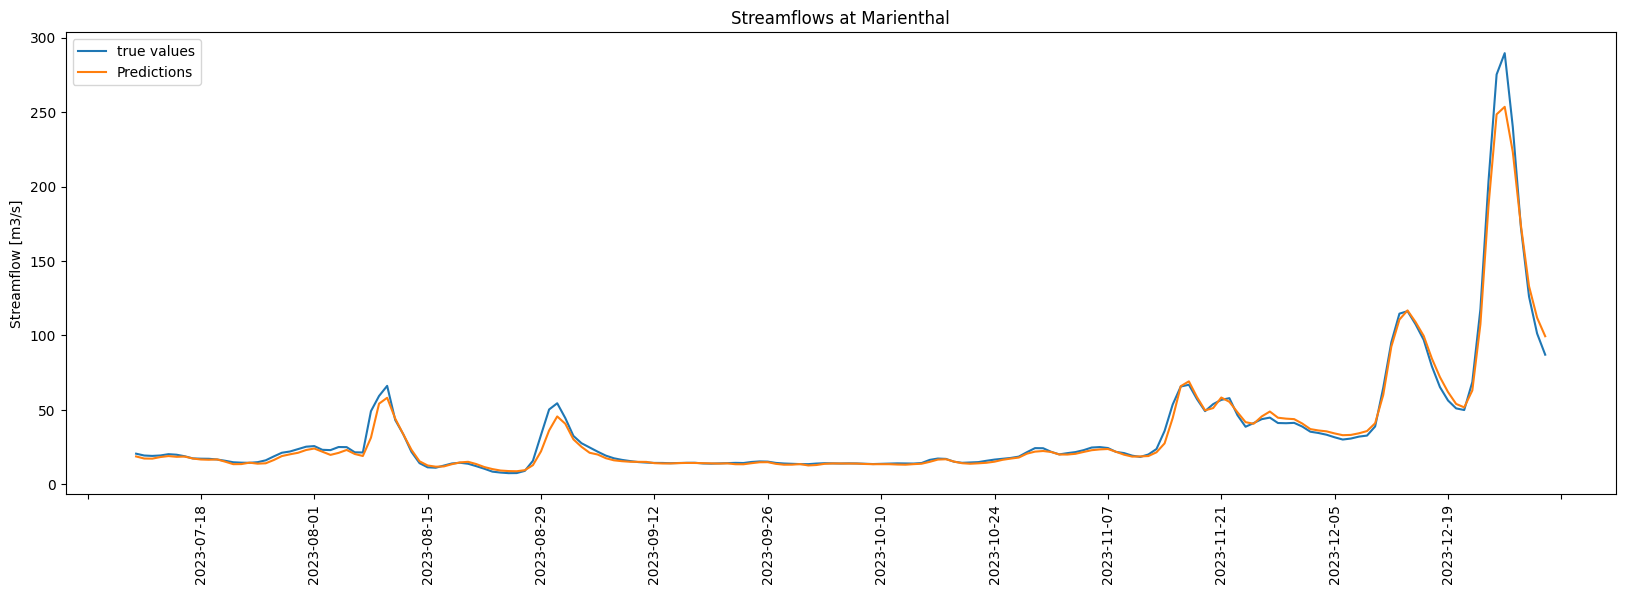

In [90]:
import matplotlib.dates as mdates


stream_plot = stream.set_index('Datum')
predictions_np = predictions.output.squeeze()[:,max_pred_len-1].numpy()
# true_values_np = predictions.y[0].view(-1, 1).squeeze().numpy()

# Plotting

plt.figure(figsize=(20, 6))


plt.plot(stream_plot.index[-175:],stream_plot['15207507_smooth'].iloc[-175:].values,  label = 'true values')

plt.plot(predictions_np, label='Predictions')


plt.ylabel('Streamflow [m3/s]')
plt.title('Streamflows at Marienthal')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.xticks(rotation=90)
plt.show()